 #   Projekt: Detekcja obiektów na obrazie 
### Autor: Rafał Ziemianek

In [1]:
#import
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from skimage import io,img_as_ubyte,filters
from scipy import ndimage as ndi
from scipy.spatial import distance
from operator import itemgetter
import cv2
import math

In [2]:
def show2imgs(im1, im2, title1='Obraz pierwszy', title2='Obraz drugi', size=(10,10)):
    
    f, (ax1, ax2) = plt.subplots(1,2, figsize=size)
    ax1.imshow(im1, cmap='gray')
    ax1.axis('off')
    ax1.set_title(title1)

    ax2.imshow(im2, cmap='gray')
    ax2.axis('off')
    ax2.set_title(title2)
    plt.show()

E:\programy\Anakonda\envs\py36\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


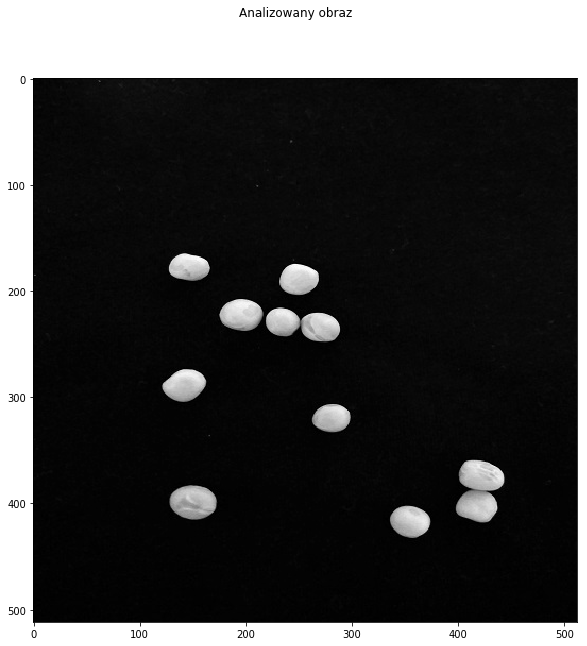

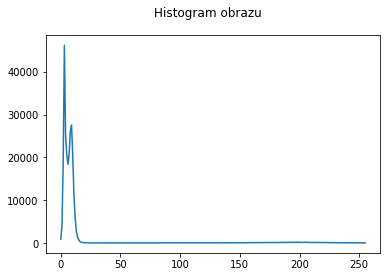

In [7]:
#wczytanie obrazu
from skimage.color import rgb2gray
image = io.imread( './images/test12.jpg')
image = rgb2gray(image)
image = img_as_ubyte(image)

plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')
plt.suptitle('Analizowany obraz')
plt.axis('on')
plt.show()


bins=np.arange(0, 257)
histo = np.histogram(image, bins=bins)
hist, bins = histo

plt.plot(bins[:-1], hist)
plt.suptitle('Histogram obrazu')
plt.show()


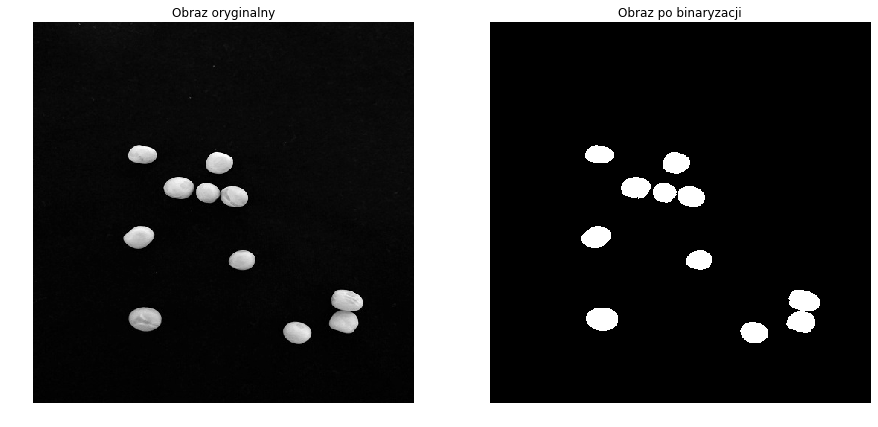

In [8]:
#binaryzacja
th = 120
th, bim = cv2.threshold(image, thresh=th, maxval=255, type=cv2.THRESH_BINARY)

show2imgs(image, bim, title1='Obraz oryginalny', title2='Obraz po binaryzacji', size=(15,15))

In [9]:
#Liczenie procentowe obektów na obrazie
def licz (pic):
    licznik,full =0,0
    
    for i in range(pic.shape[0]):
        for j in range(pic.shape[1]):
            full=full+1
            if pic[i,j] == 255:
                licznik =licznik+1
                
    wynik = (licznik/full)*100
    
    print("Punkty obiektów: ",licznik,"\npunkty całego obrazu: ",full)
    return print("wynik: %.2f" %wynik,"%")

print("Obiekty stanowią następującą część obrazu :")    
licz(bim)


Obiekty stanowią następującą część obrazu :
Punkty obiektów:  9310 
punkty całego obrazu:  262144
wynik: 3.55 %


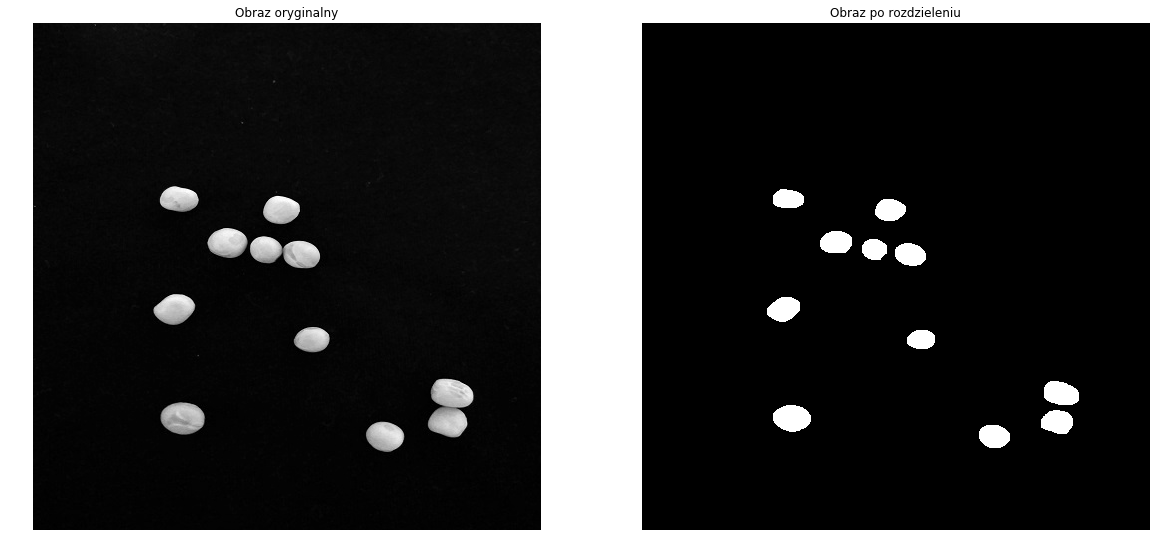

In [10]:
#Rozłączenie obiektów
element = np.ones((3,3),np.uint8)

openingIm = cv2.morphologyEx(bim, op=cv2.MORPH_OPEN, kernel=element, iterations=5)
openingIm = cv2.erode(openingIm,kernel=element,iterations=2)
show2imgs(image, openingIm, title1='Obraz oryginalny', title2='Obraz po rozdzieleniu', size=(20,20))

In [11]:
#liczenie obiektów na obrazie
label_objects, nb_labels = ndi.label(openingIm)

sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 20
mask_sizes[0] = 0

figures = mask_sizes[label_objects]

print("Wymiary obrazu : ",figures.shape)
print("Liczba obiektów na obrazie :",nb_labels)


Wymiary obrazu :  (512, 512)
Liczba obiektów na obrazie : 11


In [12]:
#liczenie punktów obiektów
def getFigure(labelledImage, objNumber):
    
    points = []
    for y in range(labelledImage.shape[0]):
        for x in range(labelledImage.shape[1]):
            if labelledImage[y,x] == objNumber:
                points.append((y,x))

    return points

In [13]:
#liczenie środka ciężkości
def cog(labelledImage, objNumber):
    cx = 0
    cy = 0
    for y in range(labelledImage.shape[0]):
        for x in range(labelledImage.shape[1]):
            if labelledImage[y,x] == objNumber:
                cy = cy + y
                cx = cx + x

    cx = cx / sizes[objNumber]
    cy = cy / sizes[objNumber]

    return int(cy), int(cx)

cogs = []
for i in range(nb_labels):
    cogs.append(cog(label_objects, i+1))

print(cogs)

[(177, 146), (189, 249), (221, 195), (228, 233), (234, 269), (288, 142), (319, 280), (374, 421), (398, 150), (402, 417), (416, 354)]


In [3]:
def cog2(points):
    mx=0
    my=0
    for (y,x) in points:
        mx = mx + x
        my = my + y
    mx = mx/len(points)
    my = my/len(points)
    
    return [my, mx]

In [15]:
#rysowanie środków ciężkości
def drawMarkers(image, coords):

    image = np.copy(image)
    
    for item in coords:
        y,x = item
        for j in range(y-4, y+4):
            image[j,x] = 0
        for i in range(x-4, x+4):
            image[y,i] = 0
            
    return image

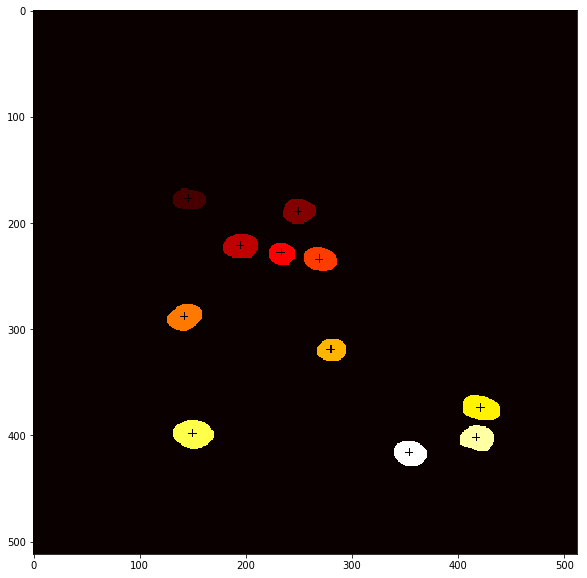

Liczba punktow:  488  Srodek ciezkosci:  [177.52868852459017, 146.5983606557377]
Liczba punktow:  572  Srodek ciezkosci:  [189.05769230769232, 249.59615384615384]
Liczba punktow:  612  Srodek ciezkosci:  [221.84967320261438, 195.2238562091503]
Liczba punktow:  423  Srodek ciezkosci:  [228.92198581560282, 233.88179669030734]
Liczba punktow:  563  Srodek ciezkosci:  [234.09946714031972, 269.8436944937833]
Liczba punktow:  618  Srodek ciezkosci:  [288.7330097087379, 142.373786407767]
Liczba punktow:  470  Srodek ciezkosci:  [319.6021276595745, 280.8212765957447]
Liczba punktow:  683  Srodek ciezkosci:  [374.0146412884334, 421.50219619326504]
Liczba punktow:  792  Srodek ciezkosci:  [398.72222222222223, 150.4848484848485]
Liczba punktow:  606  Srodek ciezkosci:  [402.52145214521454, 417.9950495049505]
Liczba punktow:  581  Srodek ciezkosci:  [416.8726333907057, 354.75215146299485]


In [16]:
lo = drawMarkers(label_objects, cogs)
plt.figure(figsize=(10,10))
plt.imshow(lo,cmap='hot')
plt.show()

for i in range(nb_labels):
    pts = getFigure(label_objects, i+1)
    print('Liczba punktow: ',len(pts),' Srodek ciezkosci: ',cog2(pts))


In [17]:
#Współczynnk Blaira-Blissa
def computeBB(points):
    s = len(points)
    my,mx = cog2(pts)
    
    r = 0
    for point in points:
         r = r + distance.euclidean(point,(my,mx))**2
            
    return s/(math.sqrt(2*math.pi*r))

In [18]:
#współczynnik Fereta
def computeFeret(points):
    
    px = [x for (y,x) in points]
    py = [y for (y,x) in points]
    
    fx = max(px) - min(px)
    fy = max(py) - min(py)
    
    return float(fy)/float(fx)    

In [4]:
for i in range(nb_labels):
    pts = getFigure(label_objects, i+1)
    bb = computeBB(pts)
    feret = computeFeret(pts)
    
    print('Blair-Bliss: ', bb,'\nFeret: ',feret, '\n---')

NameError: name 'nb_labels' is not defined